In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as Pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# libraries that used to turn off warnings.
import warnings
warnings. filterwarnings('ignore')

# libraries to be used for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# libraries to be used for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint ,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
# loading dataset
dir_path = "/content/drive/MyDrive/data1a/training"

validation_path = "/content/drive/MyDrive/data1a/validation"

In [4]:
target_size = (224,224)

pred_labels = {'01-whole':0,'00-damage':1}

In [5]:
def load_datasets(path):
  x = []
  labels = []

  # It lists and sorts the images in the path we send.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths :
    # Images in the specified path are read with the openCV library.
    img = cv2.imread(image_path)
    # Read images are rescaled according to the initially specified target_size.
    img = cv2.resize(img, target_size)
    # Scaled images are added to the x list.
    x.append(img)
    # When each path is separated by the ' / ' expression, the second to last element of the returned list represents labe11.
    label = image_path.split(os.path.sep)[-2]
    # Appending labels with waste labels key - value
    labels.append(pred_labels[label])


  # The data set is shuffled randomly.
  x, labels = shuffle(x, labels, random_state=42)
  # Size and Class Information is reported.
  print(f"X size: {np.array(x).shape}")
  print(f"Label class length: {len(np.unique(labels))} Observation Length: {len(labels)}")
  return x, labels

In [6]:
x, labels = load_datasets(dir_path)

X size: (1840, 224, 224, 3)
Label class length: 2 Observation Length: 1840


In [ ]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


In [ ]:
# visualizing image
def visualize_image(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(pred_labels.keys()))[to_categorical(labels,num_classes=2)[n]==1][0].title())
    plt.axis('off')


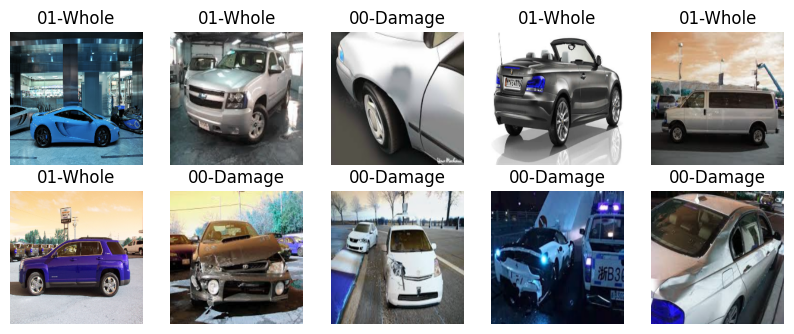

In [ ]:
visualize_image(x,labels)

In [ ]:
# data augmentation
# We define a generator for the train data set.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# We define a generator for the test data set.
test = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [ ]:
train_generator = train.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            class_mode='categorical',
                                            subset='training')

test_generator = test.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          batch_size=251,
                                          class_mode='categorical',
                                          subset='validation')

Found 1656 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',input_shape=(input_shape),activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2)) # to prevent overfitting
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(rate=0.2))


model.add(Dense(units=2,activation='sigmoid'))

# it is a 6-class classification problem, unit=6
# class > 2 -> softmax | class <= 2 -> sigmoid


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 32)       

In [ ]:
model.compile(loss = 'binary_crossentropy', # because target class > 2, if categoricall class==2, we use binary_crossentropy
              optimizer ='adam', # alternatively we can use 'scd'
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose =1, mode='min'),
             ModelCheckpoint(filepath='carpredmodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weight_only=False, verbose = 1)]


In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs = 100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers = 4,
                              steps_per_epoch = 2276//32,
                              validation_steps = 251//32)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.6940 - precision: 0.5094 - recall: 0.4797 - acc: 0.5106
Epoch 1: val_loss improved from inf to 0.69299, saving model to carpredmodel.h5
71/71 [==============================] - 282s 4s/step - loss: 0.6940 - precision: 0.5094 - recall: 0.4797 - acc: 0.5106 - val_loss: 0.6930 - val_precision: 0.5116 - val_recall: 0.4783 - val_acc: 0.5109
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.6871 - precision: 0.5673 - recall: 0.4227 - acc: 0.5596
Epoch 2: val_loss improved from 0.69299 to 0.65542, saving model to carpredmodel.h5
71/71 [==============================] - 287s 4s/step - loss: 0.6871 - precision: 0.5673 - recall: 0.4227 - acc: 0.5596 - val_loss: 0.6554 - val_precision: 0.6818 - val_recall: 0.6522 - val_acc: 0.6739
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.6798 - precision: 0.5770 - recall: 0.6042 - acc: 0.5905
Epoch 3: val_loss did not improve from 0.65542
71/7

Load Model

In [7]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/carpredmodel.h5')

In [ ]:
"""
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)
plt.show()
"""

"\nplt.figure(figsize=(20,5))\nplt.subplot(1,2,1)\nplt.plot(history.history['acc'],label='Training Accuracy')\nplt.plot(history.history['val_acc'],label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.xlabel('Epoch', fontsize=16)\nplt.ylabel('Accuracy', fontsize=16)\nplt.ylim([min(plt.ylim()),1])\nplt.title('Training and Validation Accuracy',fontsize=16)\n\n\nplt.subplot(1,2,2)\nplt.plot(history.history['loss'],label='Training Loss')\nplt.plot(history.history['val_loss'],label='Validation Loss')\nplt.xlabel('Epoch', fontsize=16)\nplt.ylabel('Loss', fontsize=16)\nplt.ylim([0, max(plt.ylim())])\nplt.title('Training and Validation Loss',fontsize=16)\nplt.show()\n"

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size = 32)

1/1 [==============================] - 10s 10s/step - loss: 0.2859 - precision: 0.8913 - recall: 0.8913 - acc: 0.8913


In [ ]:
print('\nTest accuracy: %.1f%%' % (100.0 * acc))
print('\nTest loss: %.1f%%' % (100.0 * loss))
print('\nTest precision: %.1f%%' % (100.0 * precision))
print('\nTest recall: %.1f%%' % (100.0 * recall))


Test accuracy: 89.1%

Test loss: 28.6%

Test precision: 89.1%

Test recall: 89.1%


In [ ]:
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis =1)

y_test = np.argmax(y_test, axis =1)

6/6 [==============================] - 7s 1s/step


In [ ]:
target_names = list(pred_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    01-whole       0.95      0.83      0.88        92
   00-damage       0.85      0.96      0.90        92

    accuracy                           0.89       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.90      0.89      0.89       184



In [ ]:
cm = confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt='.2f' if normalize else 'd'
  thresh = cm.max() / 2,
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j], fmt),
             horizontalalignment='center',
             color ='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

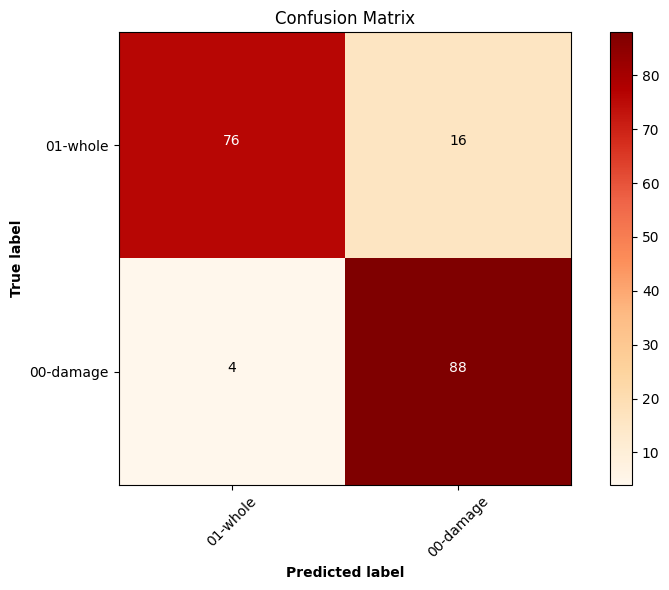

In [ ]:
plot_confusion_matrix(cm, pred_labels.keys(),
                      title='Confusion Matrix',
                      cmap=plt.cm.OrRd)

In [8]:
def model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class


In [9]:
prediction_labels = {0:"damage",1:"whole"}

In [10]:
img1,p1,predicted_class1 = model_testing('/content/drive/MyDrive/data1a/training/00-damage/0005.JPEG') # damaged -> 1
img2,p2,predicted_class2 = model_testing('/content/drive/MyDrive/data1a/training/00-damage/0032.JPEG') # damaged -> 1
img3,p3,predicted_class3 = model_testing('/content/drive/MyDrive/data1a/training/01-whole/0031.jpg') # whole -> 0
img4,p4,predicted_class4 = model_testing('/content/drive/MyDrive/data1a/training/01-whole/0046.jpg') # whole -> 0

#img5,p5,predicted_class5 = model_testing('/content/drive/MyDrive/data1a/validation/00-damage/0034.JPEG') # damaged
img5,p5,predicted_class5 = model_testing('/content/drive/MyDrive/cars_eren/damage_1.PNG') # damaged
# img6,p6,predicted_class6 = model_testing('/content/drive/MyDrive/data1a/validation/01-whole/0034.jpg') # damaged
img6,p6,predicted_class6 = model_testing('/content/drive/MyDrive/cars_eren/whole_1.jpeg')
# img7,p7,predicted_class7 = model_testing('/content/drive/MyDrive/data1a/validation/00-damage/0045.JPEG') # damaged
img7,p7,predicted_class7 = model_testing('/content/drive/MyDrive/cars_eren/whole_2.jpeg')
# img8,p8,predicted_class8 = model_testing('/content/drive/MyDrive/data1a/validation/01-whole/0041.jpg') # damaged
img8,p8,predicted_class8 = model_testing('/content/drive/MyDrive/cars_eren/damage_3.jpeg')

img9,p9,predicted_class9 = model_testing('/content/drive/MyDrive/cars_eren/damage_6.jpeg')
img10,p10,predicted_class10 = model_testing('/content/drive/MyDrive/data1a/validation/00-damage/0044.JPEG')
img11,p11,predicted_class11 = model_testing('/content/drive/MyDrive/cars_eren/whole_3.jpg')
img12,p12,predicted_class12 = model_testing('/content/drive/MyDrive/cars_eren/whole_4.jpeg')



1/1 [==============================] - 0s 40ms/step


Text(0.5, 1.0, 'Maximum Probability: 0.9983008\nPredicted class: whole')

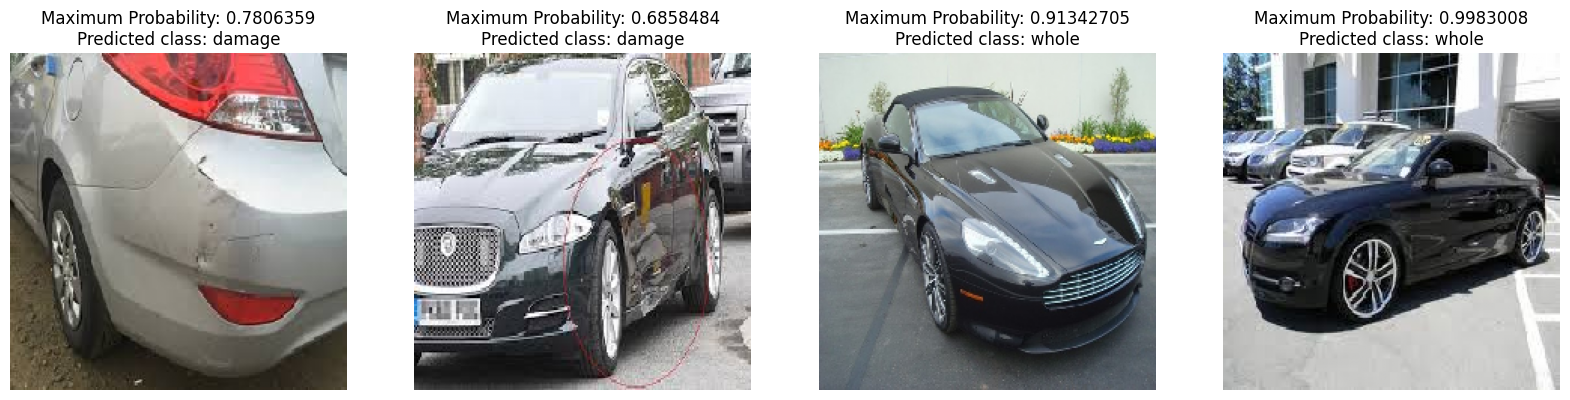

In [11]:
"""plt.figure(figsize=(20,60))
#1
plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: '+str(np.max(p1[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class1]))
plt.imshow(img1)
#2
plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maximum Probability: '+str(np.max(p2[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class2]))
plt.imshow(img2)
#3
plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maximum Probability: '+str(np.max(p3[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class3]))
plt.imshow(img3)
#4
plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maximum Probability: '+str(np.max(p4[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class4]))
plt.imshow(img4)

#5
plt.subplot(241)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: '+str(np.max(p1[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(242)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: '+str(np.max(p1[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(243)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: '+str(np.max(p1[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(244)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: '+str(np.max(p1[0],axis=-1)) + "\n" +"Predicted class: " + str(prediction_labels[predicted_class1]))
plt.imshow(img1)"""
plt.figure(figsize=(20, 60))

# First row of subplots
plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class1]))

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class2]))

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class3]))

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class4]))



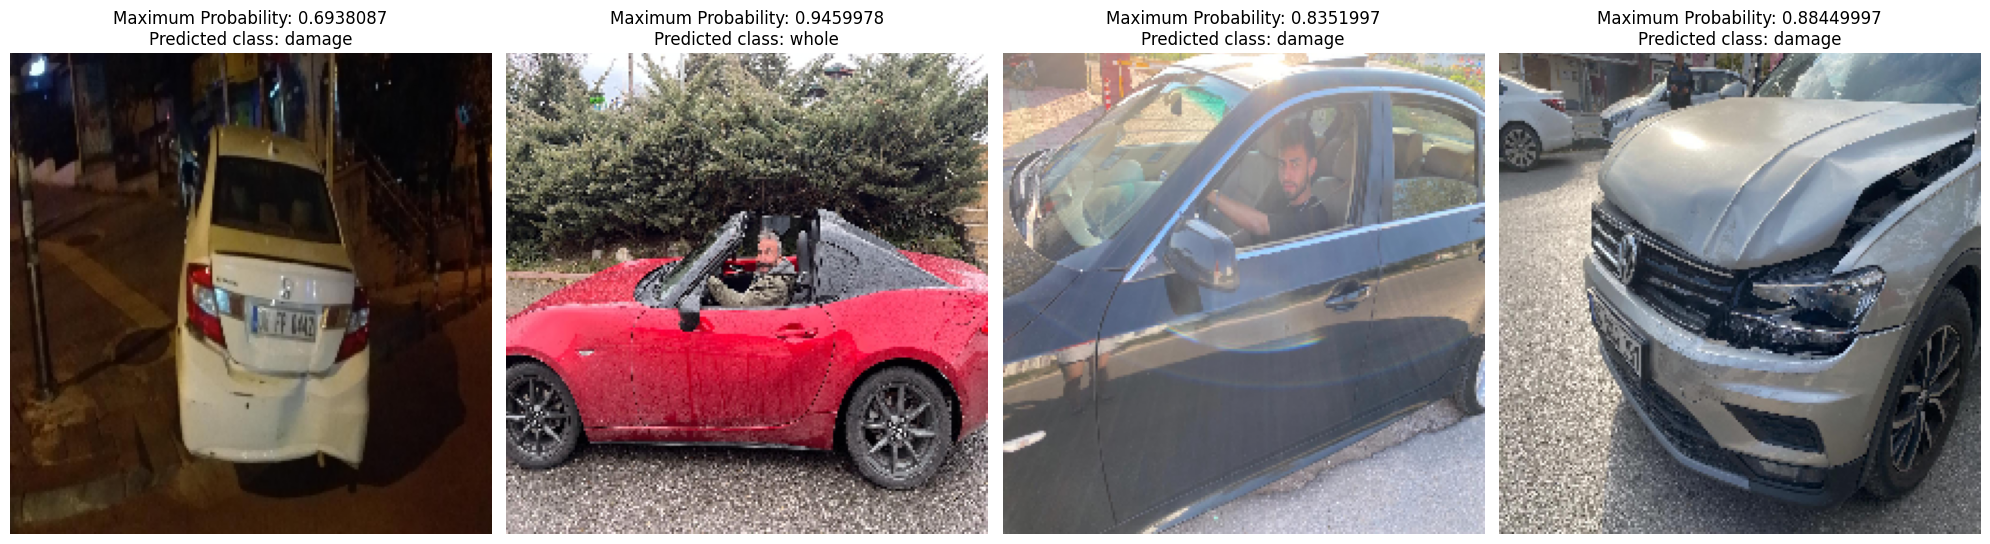

In [ ]:
plt.figure(figsize=(20, 60))

# Second row of subplots
plt.subplot(141)
plt.axis('off')
plt.imshow(img5.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p5[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class5]))

plt.subplot(142)
plt.axis('off')
plt.imshow(img6.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p6[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class6]))

plt.subplot(143)
plt.axis('off')
plt.imshow(img7.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p7[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class7]))

plt.subplot(144)
plt.axis('off')
plt.imshow(img8.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p8[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class8]))
plt.tight_layout()
plt.show()


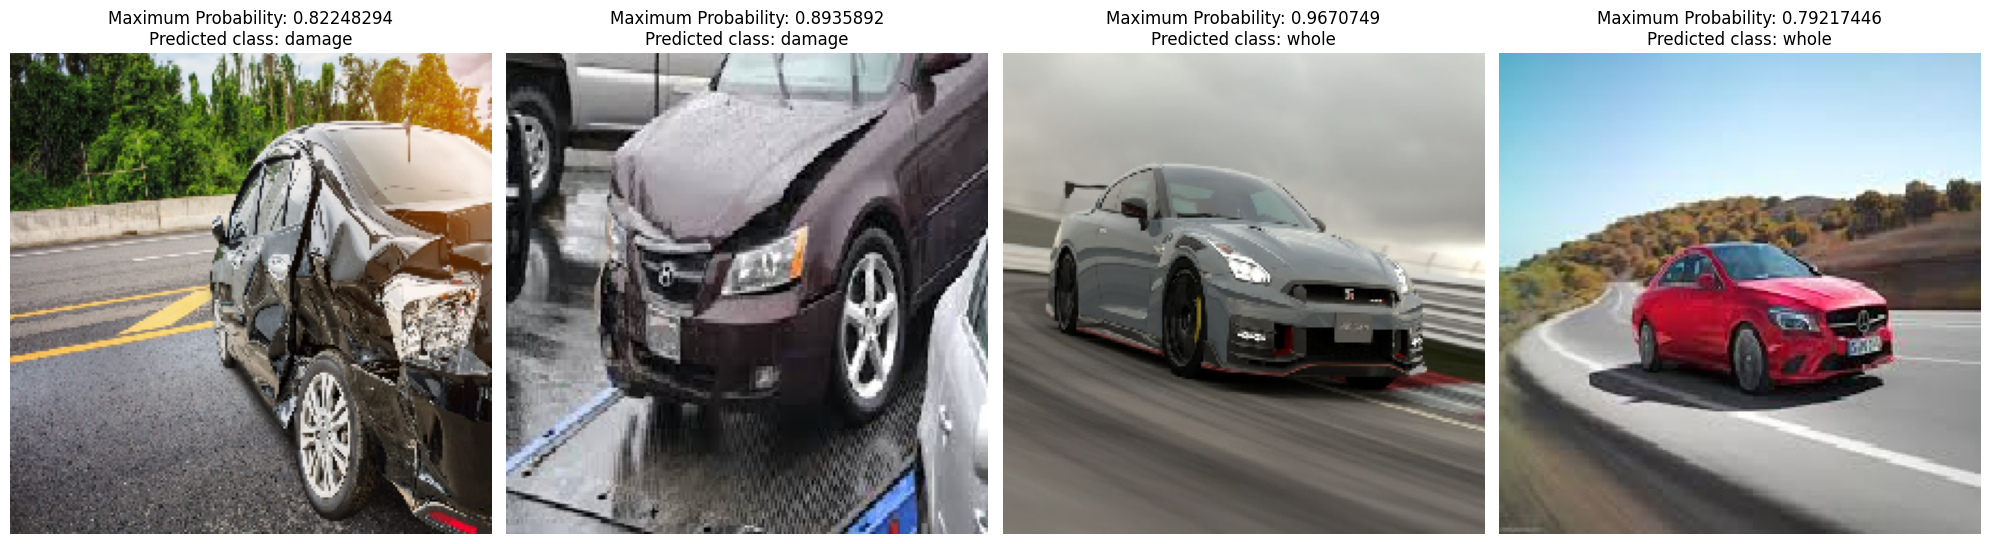

In [12]:
plt.figure(figsize=(20, 60))

# Second row of subplots
plt.subplot(141)
plt.axis('off')
plt.imshow(img9.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p9[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class9]))

plt.subplot(142)
plt.axis('off')
plt.imshow(img10.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p10[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class10]))

plt.subplot(143)
plt.axis('off')
plt.imshow(img11.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p11[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class11]))

plt.subplot(144)
plt.axis('off')
plt.imshow(img12.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p12[0], axis=-1)) + "\n" + "Predicted class: " + str(prediction_labels[predicted_class12]))
plt.tight_layout()
plt.show()